# Recognition Parametrized Gaussian Process Factror Analysis (RP-GPFA): Multimodal Time series

Observations $\mathcal{X} = \{ x_{jt}, j=1:2, t=1:T \}$:
- $j=1$: Videos of moving ellipsoid in a room. 
- $j=2$: Audio Snippets emitted from one of the ellipsoid and recorded from the 4 corner of the room.

The conditional independence relationship factorises across time ($t$) and modalities ($j$):

$$ \mathsf{P_{\theta}}(\mathcal{X}, \mathcal{Z}) = \mathsf{p_{\theta_z}}(\mathcal{Z}) \prod_{j,t} \left( \mathsf{p_{0,jt}}(\mathsf{x_{jt}}) \frac{\mathsf{f_{\theta j}}(\mathsf{z_{t}} | \mathsf{x_{jt}})}{\mathsf{F_{\theta j}}(\mathsf{z}_{t})} \right) $$


 <div align="center">
     <img src="figures/rpgpfa.png" width="1000"/>
 </div>
 
3 agents navigate in a bounded environment. Their locations are observed in the form of 3D-rendered image frames
and range-finding sensor data giving the distances of one of the agents from the four corners of the room
 (slightly differs from original [paper](https://arxiv.org/abs/2209.05661) for compactness). In this setting, a (2D) latent inducing conditional independence should recover the location of the range-finder-equipped agent, ignoring the other agents and the rest of the image data. RP-GPFA learns:

1. the nonlinear mapping from distance to position signal

2. to track a moving agent

3. which agent to track amongst the distractors.
 
 
 ### Dataset Can Be Downloaded [Here](https://drive.google.com/file/d/1WkCVPcERyMEmTMEJKMPddhwmDvcnV-fN/view?usp=drive_link)

In [1]:
import torch
import numpy as np
from torch import matmul
import matplotlib.pyplot as plt
import torch.nn.functional as F
from recognition_parametrised_model import RPM
import pickle

# Helper Function
def normalize_observations(obs, num_event_dim=1):

    full_dim = obs.shape
    batch_dim = torch.tensor(obs.shape[:num_event_dim])
    event_dim = torch.tensor(obs.shape[num_event_dim:])

    obs = obs.reshape(batch_dim.prod(), event_dim.prod())
    o_mean, o_std = torch.mean(obs, dim=0, keepdim=True), torch.std(obs, dim=0, keepdim=True)
    obs = (obs - o_mean) / (o_std + 1e-6)
    obs = obs.reshape(full_dim)

    return obs

# Load Dataset
dname = '../multimodal_dataset.pickle'
with open(dname, 'rb') as handle:
    load = pickle.load(handle)

# Modalities
latent_true = load['latent_true']
obs_sound = load['obs_sound']
obs_videos = load['obs_videos']
obs_distance = load['obs_distance']
    
# GPUs ?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data type: float64 / float32
data_type = torch.float32
torch.set_default_dtype(data_type)

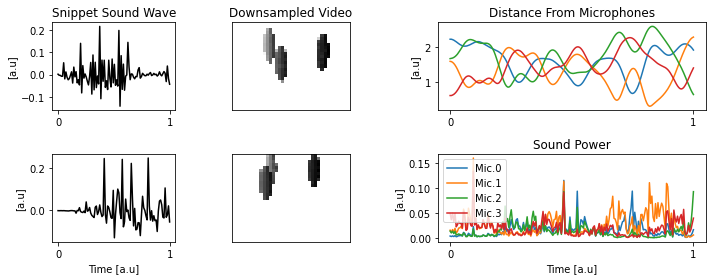

In [2]:
nn = 0
t1 = 1
t2 = 20

tsnip = np.linspace(0, 1, obs_sound[nn][t1, 0].shape[0])
tobs =  np.linspace(0, 1, obs_sound[nn].shape[0])

plt.figure(figsize=(10, 4))
plt.subplot(2, 4, 1)
plt.plot(tsnip, obs_sound[nn][t1, 0], 'k')
plt.xticks(ticks=[0, 1])
plt.title('Snippet Sound Wave')
plt.ylabel('[a.u]')


plt.subplot(2, 4, 5)
plt.plot(tsnip, obs_sound[nn][t2, 0], 'k')
plt.xticks(ticks=[0, 1])
plt.xlabel('Time [a.u]')
plt.ylabel('[a.u]')

plt.subplot(2, 4, 2)
plt.imshow(obs_videos[nn][t1], cmap='gray')
plt.title('Downsampled Video')
plt.xticks(ticks=[])
plt.yticks(ticks=[])

plt.subplot(2, 4, 6)
plt.imshow(obs_videos[nn][t2], cmap='gray')
plt.xticks(ticks=[])
plt.yticks(ticks=[])


plt.subplot(2, 2, 2)
for ii in range(obs_distance[nn].shape[-1]):
    plt.plot(tobs, obs_distance[nn][:, ii], label= 'Mic.' + str(ii))
plt.xticks(ticks=[0, 1])
plt.ylabel('[a.u]')
plt.title('Distance From Microphones')

    
plt.subplot(2, 2, 4)
for ii in range(obs_distance[nn].shape[-1]):
    plt.plot(tobs, (obs_sound[nn][:, ii]**2).mean(dim=-1), label= 'Mic.' + str(ii))
plt.xticks(ticks=[0, 1])
plt.ylabel('[a.u]')
plt.title('Sound Power')
plt.xlabel('Time [a.u]')
plt.legend()
plt.tight_layout()



In [3]:
# Normalize and store observations
use_sound = True
num_inducing = 50
x1 = obs_videos
x2 = (obs_sound**2).mean(dim=-1) if use_sound else obs_distance

observations = [
    torch.tensor(normalize_observations(xx, num_event_dim=1), dtype = data_type, device=device)
    for xx in [x1, x2]
]

observation_locations = torch.linspace(0, 1, observations[0].shape[1], device=device, dtype=data_type).unsqueeze(-1)
inducing_locations = observation_locations[np.floor(np.linspace(0, observations[0].shape[1]-1, num_inducing).astype(int))]

/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Text(0.5, 0, 'Epoch')

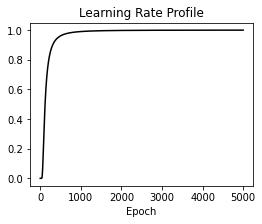

In [4]:
# Learning Rates Schedule
num_epoch = 5000
alpha =  50 / num_epoch
lr_sigmoid = lambda xx: np.exp(- 1 / ((xx + 1) * alpha) ** 2)
xx = np.arange(num_epoch)
yy = lr_sigmoid(xx)

plt.figure(figsize=(4, 3))
plt.plot(xx, yy, c='k')
plt.title('Learning Rate Profile')
plt.xlabel('Epoch')
#plt.xlim([0, 300])

In [ ]:
prior_params = {
    'gp_kernel': 'RBF',
    'scale': 1,
    'lengthscale': 0.01,
    'fit_kernel_scale': False,
    'fit_kernel_scale_prior': False,
    'fit_kernel_lengthscale': True,
    'fit_kernel_lengthscale_prior': False,
    'fit_prior_mean_param': False,
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
    'scheduler': lambda optim: torch.optim.lr_scheduler.LambdaLR(optim, lr_sigmoid),
}

factors_params = {
    'channels': [[1, 10, 10, 10], []],
    'kernel_conv': [[4, 4, 4], []],
    'kernel_pool': [[2, 2, 1], [], []],
    'dim_hidden': [[50, 50], [50, 50, 50]],
    'non_linearity': [F.relu, F.relu],
    'covariance': ['fixed', 'fixed'],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
    'scheduler': lambda optim: torch.optim.lr_scheduler.LambdaLR(optim, lr_sigmoid),
}

auxiliary_params = {
    'channels': [[1, 10, 10, 10], []],
    'kernel_conv': [[4, 4, 4], []],
    'kernel_pool': [[2, 2, 1], [], []],
    'dim_hidden': [[50, 50], [50, 50, 50]],
    'non_linearity': [F.relu, F.relu],
    'covariance': ['fixed', 'fixed'],
    'zero_init': True,
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=0*1e-3),
    'scheduler': lambda optim: torch.optim.lr_scheduler.LambdaLR(optim, lr_sigmoid),
}

variational_params = {
    'inference_mode': 'parametrized',  # 'amortized', 'parametrized'
    'channels': [[1, 10, 10], []],
    'kernel_conv': [[4, 4], []],
    'kernel_pool': [[2, 2], [], []],
    'dim_hidden': [[20, 20], [20, 20]],
    'dim_hidden_merged': [],
    'non_linearity': [F.relu, F.relu, F.relu],
    'non_linearity_merged': F.relu,
    'covariance': 'full',
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
    'scheduler': lambda optim: torch.optim.lr_scheduler.LambdaLR(optim, lr_sigmoid),
}

fit_params = {
    'num_epoch': num_epoch,
    'dim_latent': 2,
    'prior_params': prior_params,
    'factors_params': factors_params,
    'auxiliary_params': auxiliary_params,
    'variational_params': variational_params,
    'ergodic': False,
    'pct': 0.1
}

rpm = RPM(
    observations=observations,
    observation_locations=observation_locations,
    inducing_locations=inducing_locations,
    fit_params=fit_params,
)

rpm.fit(observations)

RPM on GPU Observations on cuda:0
Epoch 500/5000 Loss: 7.004271e+00
Epoch 1000/5000 Loss: 6.033859e+00
Epoch 1500/5000 Loss: 5.402531e+00
Epoch 2000/5000 Loss: 4.975656e+00


In [ ]:
utils_process.plot_loss(rpm)

In [ ]:
import utils_process
nn = 0
pwidth = 4 * 5
pheight = 1 * 5

fig = utils_process.plot_rpgpfa_summary(
    rpm=rpm,
    plot_id_factors=[0, 1],
    plot_id_observations=[nn],
    plot_variational=True,
    plot_regressed=True,
    plot_variance=True,
    plot_true=True,
    latent_true=latent_true[:num_observation],
    plot_type='linear',
    regress_param=None,
)

fig.set_figwidth(pwidth)
fig.set_figheight(pheight)

fig = utils_process.plot_rpgpfa_summary(
    rpm=rpm,
    plot_id_factors=[0, 1, 1],
    plot_id_observations=[nn],
    plot_variational=True,
    plot_regressed=True,
    plot_variance=True,
    plot_true=False,
    latent_true=latent_true[:num_observation],
    plot_type='2D',
    regress_param=None,
)

fig.set_figwidth(pwidth)
fig.set_figheight(pheight)


plt.subplot(1, 4, 4)
plt.cla()
plt.plot(latent_true[nn, :, 0], latent_true[nn, :, 1], c='k')
plt.ylabel('Z[2]')
plt.xlabel('Z[1]')
plt.title('True')